In [ ]:
import pathlib
import PIL
import tensorflow as tf

In [ ]:
data_train=pathlib.Path('/content/drive/MyDrive/Camerin DSML/chest_xray/train')
data_test=pathlib.Path('/content/drive/MyDrive/Camerin DSML/chest_xray/test')

In [ ]:
train_image_count=len(list(data_train.glob('*/*')))
print(train_image_count)

5216


In [ ]:
test_image_count=len(list(data_test.glob('*/*')))
print(test_image_count)

624


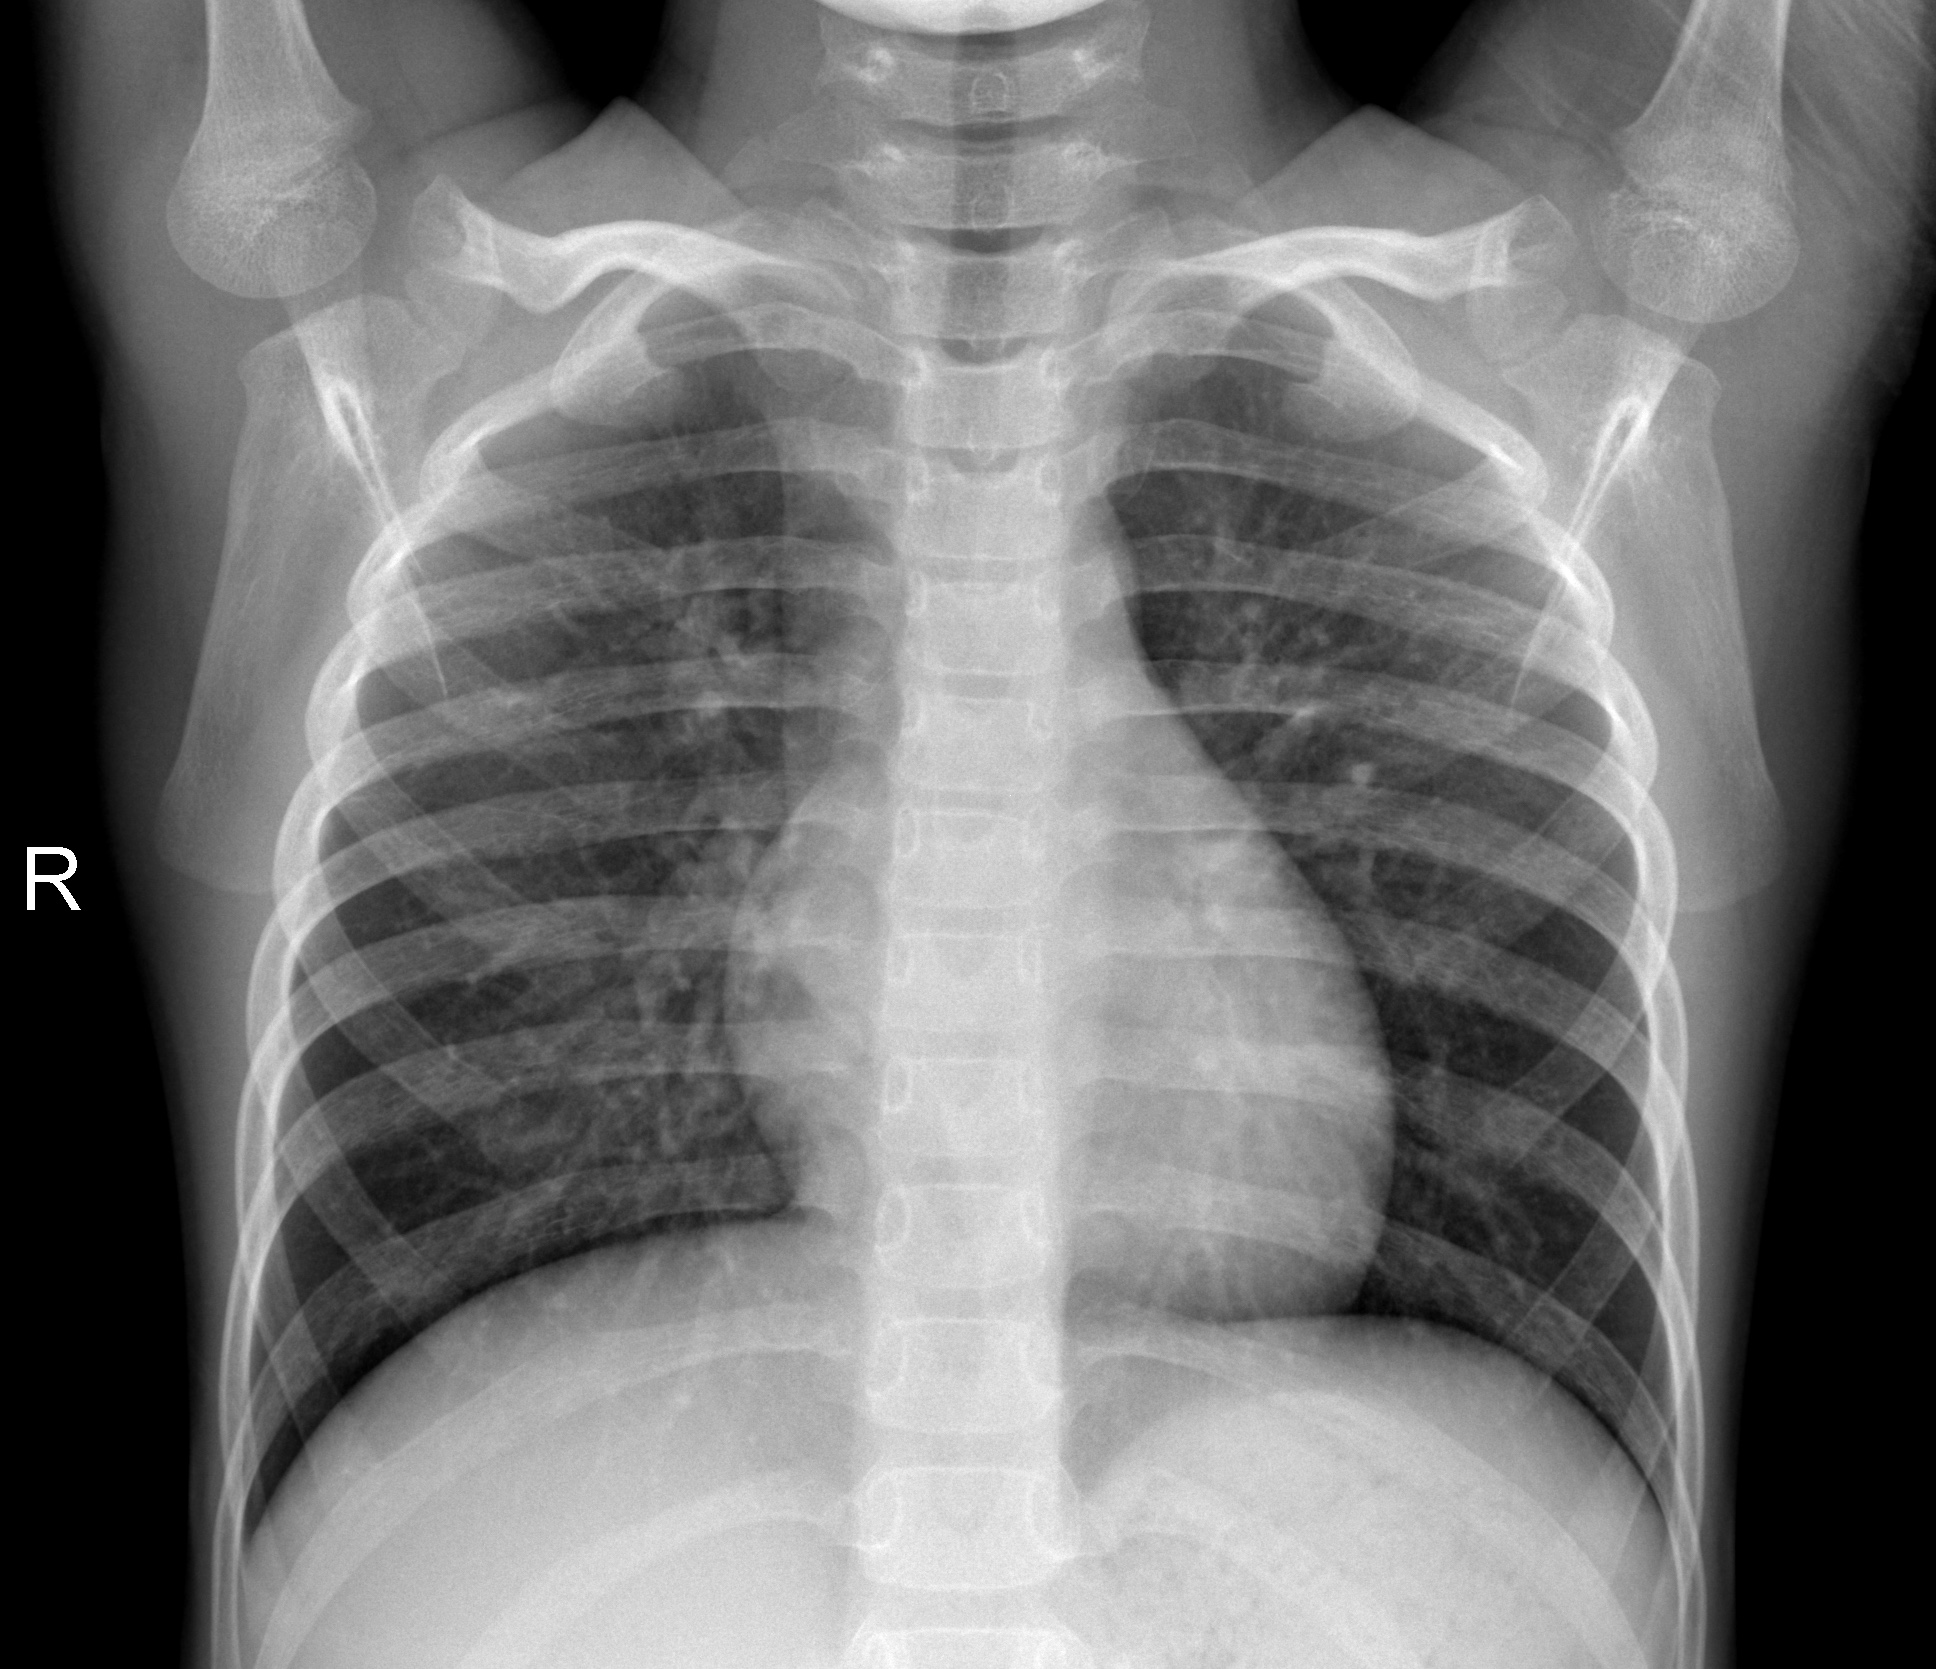

In [ ]:
Normal=list(data_train.glob('NORMAL/*'))
PIL.Image.open(str(Normal[5]))

In [ ]:
print(len(Normal))

1341


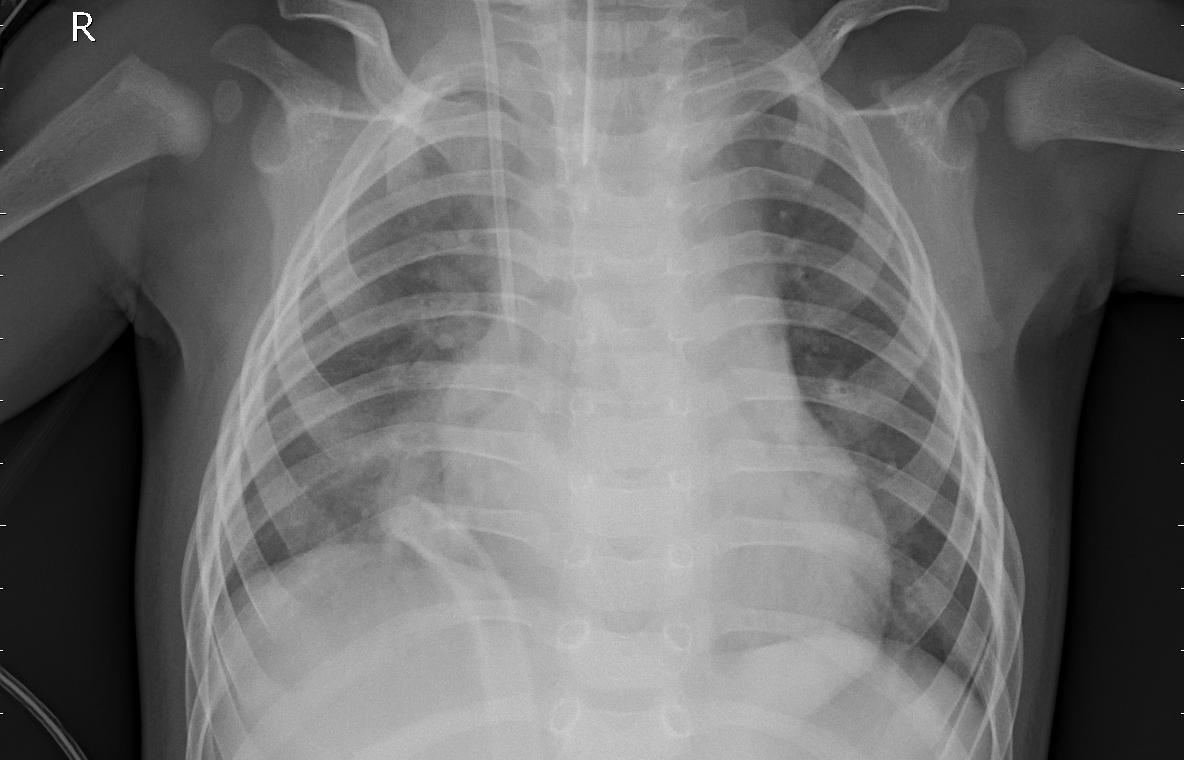

In [ ]:
Pneumonia=list(data_train.glob('PNEUMONIA/*'))
PIL.Image.open(str(Pneumonia[5]))

In [ ]:
print(len(Pneumonia))

3875


**Preprocessing**

In [ ]:
batch_size=250
img_height=200
img_width=200

In [ ]:
train_ds=tf.keras.utils.image_dataset_from_directory(data_train,
                                                     image_size=(img_height,img_width),
                                                     batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [ ]:
test_ds=tf.keras.utils.image_dataset_from_directory(data_test,
                                                    image_size=(img_height,img_width),
                                                    batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [ ]:
classes=train_ds.class_names
print(classes)

['NORMAL', 'PNEUMONIA']


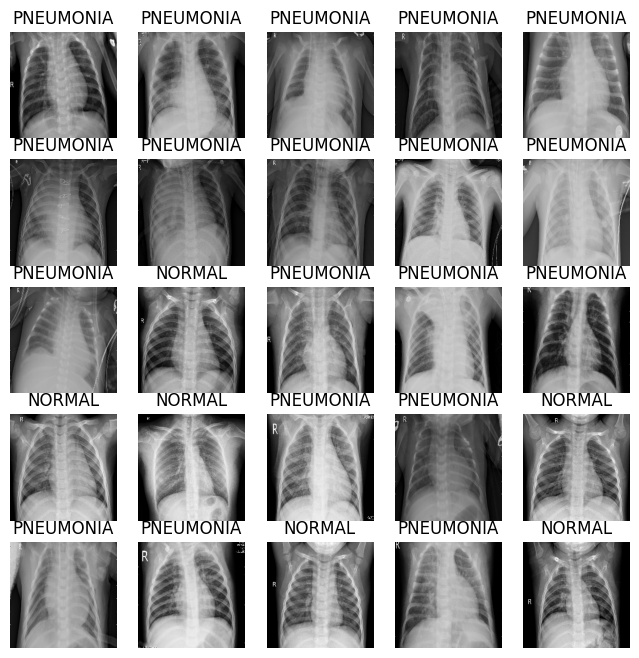

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,8))
columns=5
rows=5

for images,labels in train_ds.take(1):
  for i in range(1,columns*rows+1): # 25 images
    fig.add_subplot(rows,columns,i)
    plt.axis('off')
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[labels[i]])
plt.show()

In [ ]:
for image_batch,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(250, 200, 200, 3)
(250,)


**Data Augmentation**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
data_augmentation = Sequential([
    # DON'T flip horizontally for medical images unless you're certain it's safe.
    # layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),

    # small random rotations
    layers.RandomRotation(0.06),          # +/- ~6% of 2π -> small angle

    # small translations (height, width)
    layers.RandomTranslation(0.05, 0.05), # up to 5% shift

    # small zoom
    layers.RandomZoom(0.08),              # up to ~8% zoom

    # small contrast jitter
    layers.RandomContrast(0.10),          # +/-10% contrast
], name="data_augmentation")

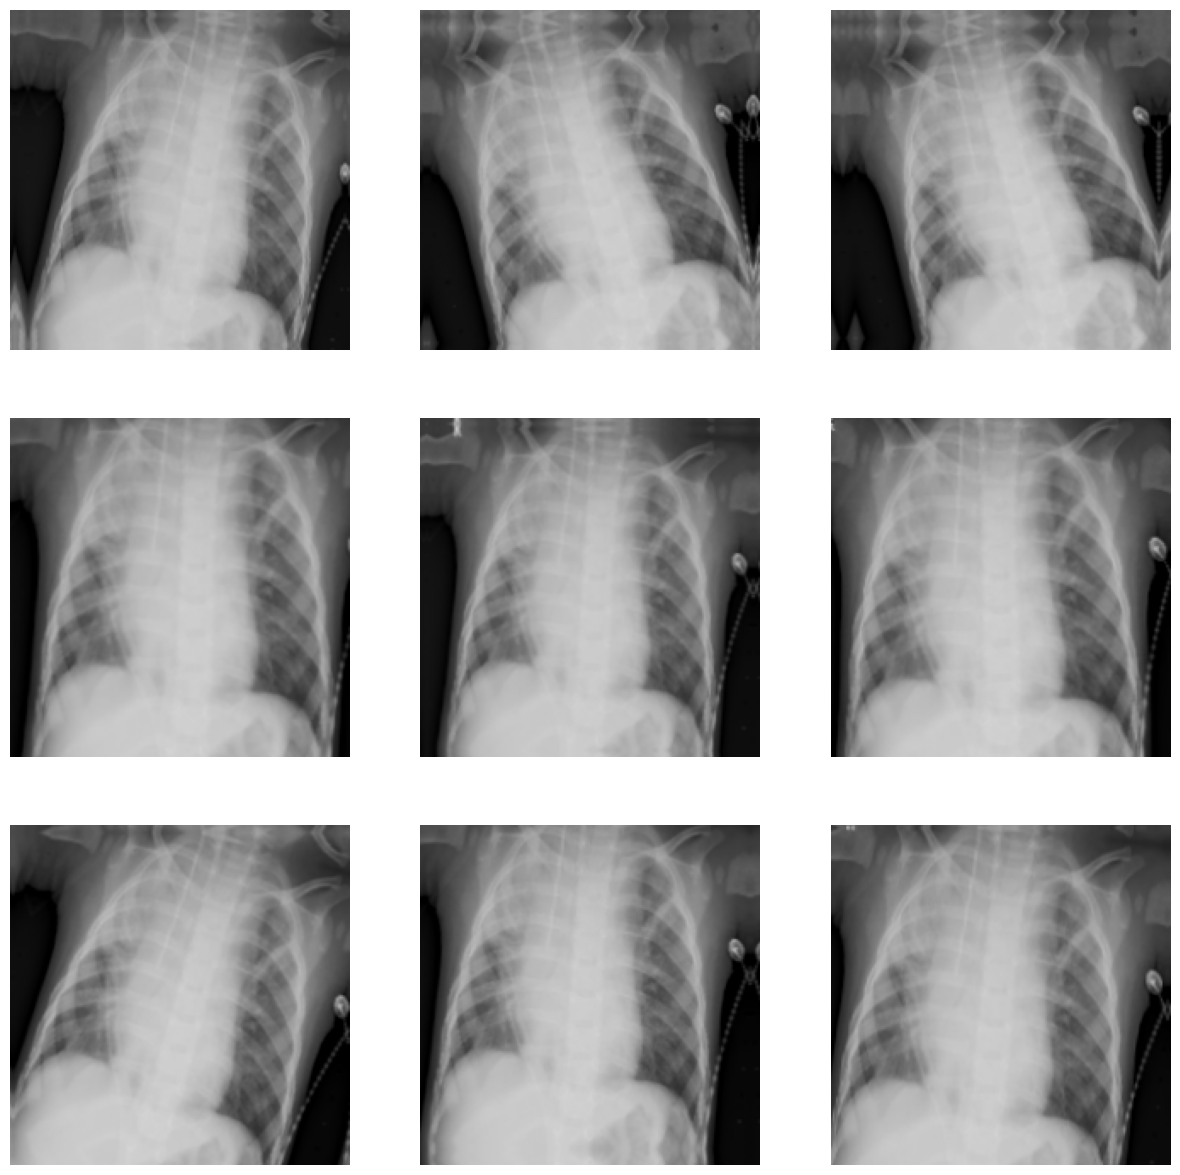

In [ ]:
plt.figure(figsize=(15,15))
for images,_ in train_ds.take(3):
  for i in range(9):
    augmented_images=data_augmentation(images)
    ax=plt.subplot(3,3,i+1) #3 images
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

**Model Building**

In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,BatchNormalization,Dropout,Dense,Flatten,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
model=Sequential([
    data_augmentation,
    layers.Rescaling(1./255), # Greyscale conversion

    layers.Conv2D(16,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)), # 1: 100x100

    layers.Conv2D(16,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)), # 2: 50x50

    layers.Conv2D(32,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)), # 3: 25x25

    layers.Conv2D(32,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)), # 4: 12x12

    layers.Conv2D(64,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)), # 5: 6x6

    layers.Conv2D(64,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)), # 6: 3x3

    layers.Conv2D(64,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    # Removed MaxPool2D here

    layers.Conv2D(128,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    # Removed MaxPool2D here

    layers.Conv2D(128,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    # Removed MaxPool2D here

    layers.Conv2D(128,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    # Removed MaxPool2D here

    layers.Conv2D(256,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    # Removed MaxPool2D here

    layers.Conv2D(256,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    # Removed MaxPool2D here

    layers.Conv2D(256,(3,3),padding='same',activation='relu'),
    layers.BatchNormalization(),
    # Removed MaxPool2D here

    # layers.Flatten(), # This line was causing the error
    GlobalAveragePooling2D(),


    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1,activation='sigmoid')
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=Adam(),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (250, 200, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (250, 200, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (250, 200, 200, 16)    │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (250, 200, 200, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (250, 100, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (250, 100, 100, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (250, 100, 100, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (250, 50, 50, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (250, 50, 50, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (250, 50, 50, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (250, 25, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (250, 25, 25, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (250, 25, 25, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (250, 12, 12, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (250, 12, 12, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (250, 12, 12, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (250, 6, 6, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (250, 6, 6, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (250, 6, 6, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (250, 3, 3, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (250, 3, 3, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (250, 3, 3, 64)        │           25

 Total params: 2,000,849 (7.63 MB)

 Trainable params: 1,997,713 (7.62 MB)

 Non-trainable params: 3,136 (12.25 KB)

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
c=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5)

In [ ]:
new_batch_size = 32

train_ds_rebatched = train_ds.unbatch().batch(new_batch_size).cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
test_ds_rebatched = test_ds.unbatch().batch(new_batch_size).cache().prefetch(buffer_size=AUTOTUNE)

history=model.fit(
    train_ds_rebatched,
    validation_data=test_ds_rebatched,
    epochs=40,
    callbacks=[callback,c]
    )

Epoch 1/40
    163/Unknown 210s 57ms/step - accuracy: 0.8029 - loss: 0.4361

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 296s 586ms/step - accuracy: 0.8033 - loss: 0.4354 - val_accuracy: 0.6250 - val_loss: 3.2790
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9353 - loss: 0.1623 - val_accuracy: 0.6250 - val_loss: 3.1667
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9400 - loss: 0.1574 - val_accuracy: 0.6362 - val_loss: 5.2584
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9538 - loss: 0.1307 - val_accuracy: 0.8686 - val_loss: 0.4213
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9588 - loss: 0.1260 - val_accuracy: 0.8782 - val_loss: 0.6878
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9583 - loss: 0.1120 - val_accuracy: 0.8974 - val_loss: 0.3318
Epoch 7/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9624 - loss: 0.1072 - val_accuracy: 0.5513 - val_loss: 2.7165
Epoch 8/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9708 - loss: 0.0870 - val_accu

0.7291666865348816
0.9723926186561584


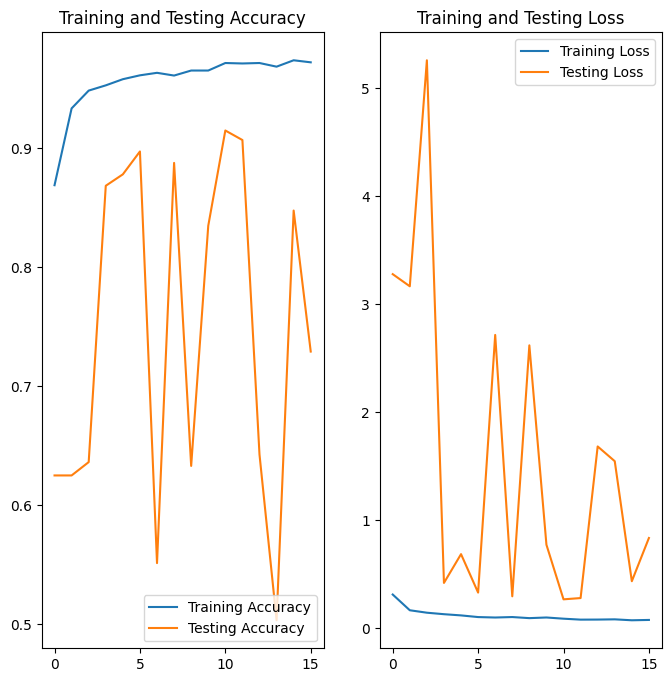

In [ ]:
acc=history.history['accuracy']
test_acc=history.history['val_accuracy']
print(f'{history.history['val_accuracy'][-1]}')
print(f'{history.history['accuracy'][-1]}')

loss=history.history['loss']
test_loss=history.history['val_loss']

epochs_range=range(16)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,test_acc,label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,test_loss,label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

**Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Raw probability: 0.24128194
Predicted class: NORMAL


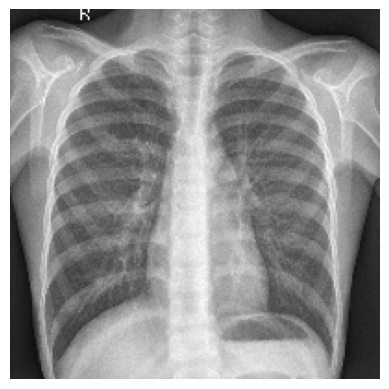

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def prediction_img(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    plt.axis('off')
    plt.imshow(img)


    prediction = model.predict(img_array)[0][0]


    print("Raw probability:", prediction)
    print("Predicted class:", classes[int(prediction > 0.5)])
prediction_img('/content/drive/MyDrive/Camerin DSML/chest_xray/test/NORMAL/IM-0007-0001.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Raw probability: 0.99995434
Predicted class: PNEUMONIA


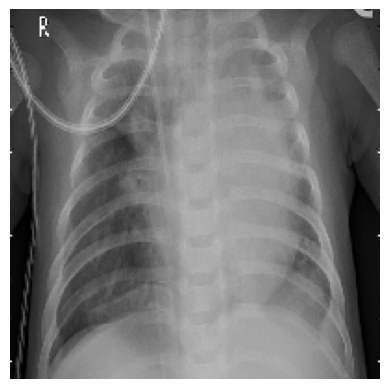

In [ ]:
prediction_img('/content/drive/MyDrive/Camerin DSML/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg')